# Topic modeling


Датесет для работы с topic modeling - информации о постах с хабра. 

In [1]:
import pandas as pd
import re
import numpy as np
import gc

In [2]:
df = pd.read_csv('recipes.csv')

In [3]:
df.head(5)

,tags,title,ingredients,time,steps,category,Калорийность,Белки,Жиры,Углеводы
0,Пошаговые рецепты/Заготовки/Грузинская кухня,Капуста по‑грузински,13411:Вода\n13410:Сахар\n13421:Соль\n14585:Укс...,30 минут + 5 суток,"0. Смешать воду, сахар и соль, довести до кипе...",zagotovki,91 ккал,"2,7 грамм","0,2 грамм","18,6 грамм"
1,Пошаговые рецепты/Заготовки/Веганская еда,Арбузный мед,14287:Арбуз,5 часов,"0. Арбуз помыть, обсушить и разрезать на четыр...",zagotovki,350 ккал,"8,4 грамм","1,4 грамм","81,2 грамм"
2,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Маринованные опята,14584:Опята\n13422:Уксус\n13421:Соль\n13460:Ла...,40 минут + 1 сутки,0. Промытые опята бросить в кипящую воду и вар...,zagotovki,36 ккал,"2,4 грамм","1,4 грамм","4,6 грамм"
3,Пошаговые рецепты/Заготовки/Русская кухня/Соле...,Соленые огурцы по бабушкиному рецепту,15137:Огурцы\n13421:Соль\n14786:Листья черной ...,30 минут + 20 суток,0. Огурцы лучше брать небольшие и плотные. Дли...,zagotovki,142 ккал,"7,4 грамм",1 грамм,"24,9 грамм"
4,Пошаговые рецепты/Заготовки/Варенье,Клубничное варенье с черным перцем,13494:Клубника\n13410:Сахар\n13427:Лимон\n1373...,1 час,0. Вымыть клубнику под проточной водой. Лучше ...,zagotovki,4460 ккал,12 грамм,"4,7 грамм","1083,9 грамм"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38615 entries, 0 to 38614
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tags          38615 non-null  object
 1   title         38610 non-null  object
 2   ingredients   38615 non-null  object
 3   time          38615 non-null  object
 4   steps         38613 non-null  object
 5   category      38615 non-null  object
 6   Калорийность  38615 non-null  object
 7   Белки         38615 non-null  object
 8   Жиры          38615 non-null  object
 9   Углеводы      38615 non-null  object
dtypes: object(10)
memory usage: 2.9+ MB


Датасет содержит 38615 рецептов.

In [5]:
def Convert(string):
    li = list(string.split("/")) 
    return li 

In [6]:
df['clean_tags'] = df['tags'].apply(Convert)

In [7]:
df['clean_tags'][1]

['Пошаговые рецепты', 'Заготовки', 'Веганская еда']

In [8]:
slist =[]
for x in df['clean_tags']:
    slist.extend(x)

In [9]:
len(set(slist))

427

В данных содержится 427 уникальных тегов.Это достаточно большое число, чтобы использовать его как количество топиков при моделировании, однако в случае, если все же разделить данные на все эти топики качество модели будет достаточно просто оценить. 

In [10]:
df['category'].value_counts()

vypechka-deserty    9412
osnovnye-blyuda     9291
zakuski             5204
salaty              4032
supy                2763
zavtraki            1971
napitki             1945
pasta-picca         1787
sousy-marinady      1288
sendvichi            566
rizotto              245
bulony                79
zagotovki             32
Name: category, dtype: int64

# 1. Preprocessing


In [11]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

In [13]:
russian_stopwords = stopwords.words("russian")

В ходе препроцессинга выполним токенизацию, удалим стоп-слова и цифры.

In [14]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = tokenizer.tokenize(str(docs[idx]))  

    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    docs = [[token for token in doc if token not in russian_stopwords] for doc in docs]
    return docs

In [15]:
docs =np.array(df['steps'])

In [16]:
docs = docs_preprocessor(docs)

# 2. Modeling

Производить тематическое моделирование будем с использовнием средств библиотеки Gensim

In [17]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases
from gensim.models import LsiModel

/usr/local/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [18]:
bigram = Phrases(docs, min_count=10)

In [19]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            docs[idx].append(token)

Создадим словарь и корпус.

In [20]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 16272
Number of documents: 38615


1. Выбор количества топиков.

Необходимо определить количество тем, по которым выполняется кластеризация датасета. Создадим серию моделей для каждой из которых посчитаем когерентность. 

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [22]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)

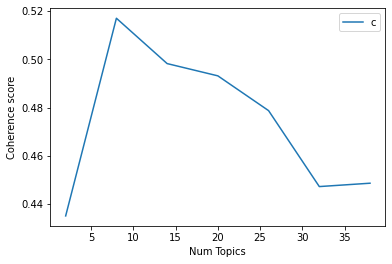

In [23]:
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
gc.collect()

3252

Значение когерентности падает при количестве топиков больше 14. Это значение почти соответствует количеству категорий (13) в данных, которое можно считать оптимальным.

In [25]:
num_topics=14

2. LSA model

In [26]:
model_lsa=LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

Вычисление UMass measure

In [27]:
coherence_model_lsa = CoherenceModel(model=model_lsa, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa)


Coherence Score:  -2.201413384097423


In [28]:
del coherence_model_lsa, coherence_lsa
gc.collect()

22

Вычисление UCI measure

In [29]:
coherence_model_lsa = CoherenceModel(model=model_lsa, texts=docs, dictionary=dictionary, coherence="c_uci")
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa)


Coherence Score:  -0.33821545656331675


In [30]:
del coherence_model_lsa, coherence_lsa
gc.collect()

22

In [31]:
del model_lsa
gc.collect()

22

3. LDA model

Вычисление UMass measure

In [32]:
model_lda=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

In [33]:
coherence_model_lda = CoherenceModel(model=model_lda, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -3.004247974610938


In [34]:
del coherence_model_lda, coherence_lda
gc.collect()

22

Вычисление UCI measure

In [35]:
coherence_model_lda = CoherenceModel(model=model_lda, texts=docs, dictionary=dictionary, coherence="c_uci")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -0.7195330621086669


In [36]:
del coherence_model_lda, coherence_lda
gc.collect()

22

**Вывод:** Значения обоих метрик показывают лучший результат при использовании LDA модели.

# 3. Visualization 

Построим интерактивный дашборд с визуализацией топиков для lda модели.

In [37]:
!pip install pyLDAvis

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [38]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [39]:
pyLDAvis.gensim_models.prepare(model_lda, corpus, dictionary)

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.183315  0.094828       1        1  14.181339
12     0.063232  0.203402       2        1  13.685485
8      0.284620 -0.116543       3        1  10.568267
6      0.151991 -0.146586       4        1  10.106726
10    -0.012828  0.138545       5        1   9.092064
3      0.115297 -0.035253       6        1   8.391855
2     -0.093543  0.175197       7        1   6.924123
1     -0.160407 -0.021881       8        1   5.786783
0      0.002409 -0.117786       9        1   4.662643
11    -0.144666 -0.091461      10        1   4.611813
13    -0.057349 -0.003041      11        1   4.210107
5     -0.034342  0.165453      12        1   3.680288
9     -0.149138 -0.182246      13        1   2.513696
7     -0.148591 -0.062627      14        1   1.584810, topic_info=             Term         Freq        Total Category  logprob  loglift
822   ингредиенты  5287.000000  5287.000000  Default  30.0000  30.0000
730      Добавьте  8845.000000  8845.000000  Default  29.0000  29.0000
685      добавьте  7821.000000  7821.000000  Default  28.0000  28.0000
1987     смешайте  5581.000000  5581.000000  Default  27.0000  27.0000
4934    добавляем  3376.000000  3376.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
430        хлопья   220.445465   490.793993  Topic14  -5.0505   3.3443
4890        кешью   168.957330   246.724652  Topic14  -5.3165   3.7661
1796        миске   302.506082  4734.049555  Topic14  -4.7340   1.3943
78          массу   260.304205  3046.653806  Topic14  -4.8843   1.6848
3226       посуде   181.012146   401.908228  Topic14  -5.2476   3.3470

[1061 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
8605      4  0.982766  Аккуратно_перемешайте
3339      3  0.975525                  Бекон
3339      5  0.009954                  Бекон
2908      8  0.975771                  Белую
8788      1  0.002385                  Берем
...     ...       ...                    ...
237      10  0.002490                   яйцо
237      11  0.068049                   яйцо
237      12  0.010788                   яйцо
237      13  0.009129                   яйцо
237      14  0.017012                   яйцо

[5079 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 13, 9, 7, 11, 4, 3, 2, 1, 12, 14, 6, 10, 8])

Если посмотреть самые релевантные слова для каждого топика можно заметить вполне понятную логику их разбиения.Так, топик 3, вероятно, относится к сфере новостей о технологиях, топик 15 - к статьям об информационной безопасности, топик 7 - к статьям о бизнес процессах и так далее.

1. **WordCloud первых 4 топиков**

In [40]:
!pip install wordcloud

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
topics = model_lda.show_topics(formatted=False)

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


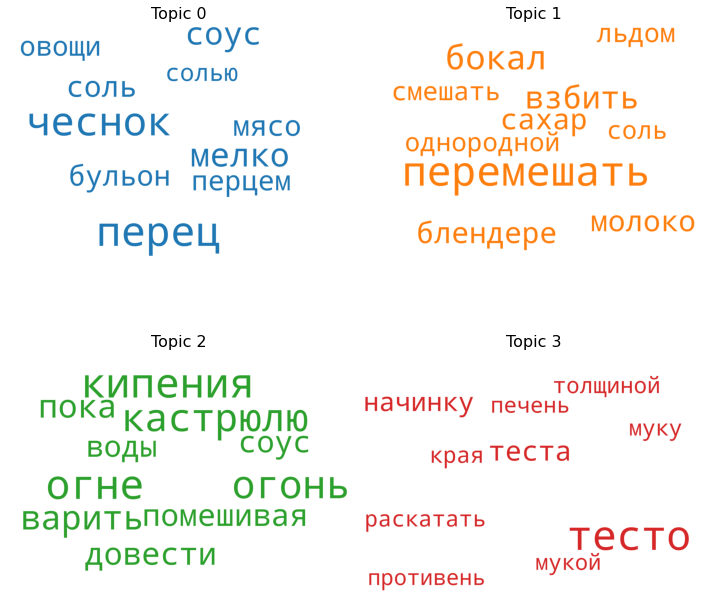

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [68]:
list_of_topics = []
for doc in corpus:
    topics = model_lda.get_document_topics(doc)
    res = [[ i for i, j in topics ],
           [ j for i, j in topics ]]    
    doc_topic = res[0][res[1].index(max(res[1]))]
    list_of_topics.append(doc_topic)

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
df['topic'] = list_of_topics

/usr/local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
